# Moment models fine-tune analysis | Mask test
> This notebook is the pre-analysis of moment models to select the cases used in the paper.

# RECORDATORIO 
1) Conseguir que compilen de nuevo
2) Enmascarar también en evaluación, no solo en training, majaretilla...

In [4]:
# Input parameters
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [5]:
#! pip install --no-deps ydata_profiling
#! pip install --no-deps dacite
#! pip install --no-deps multimethod
#! pip install --no-deps visions
#! pip install --no-deps wordcloud
#! pip install --no-deps imagehash
#! pip install --no-deps htmlmin

In [6]:
# Imports
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut
from dvats.imports import beep
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import ydata_profiling as ydp
import seaborn as sns

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7fd314bfeec0>

















In [7]:
import torch
torch.cuda.set_device(1)

In [8]:
from fastai.losses import MSELossFlat
from dvats.encoder import MAELossFlat, EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE
import dvats.config as cfg_
import gc
import os

### Setting up Weight & Biases information

In [10]:
# User and project
entity = os.environ.get("WANDB_ENTITY")
project = os.environ.get("WANDB_PROJECT")
folder = entity+'/'+project+'/'

# Dataset
dataset = 'gtrends_kohls'
dataset_version = 'v2'
enc_artifact_dataset = folder + dataset + ':' + dataset_version

# Models
model_family = 'zeroshot-moment'
task = 'embedding'
enc_artifact_small_name = folder + model_family + '-small-' + task + ':v0'
enc_artifact_base_name  =  folder + model_family + '-base-' + task + ':v0'
enc_artifact_large_name = folder + model_family + '-large-' + task + ':v0'

### Download dataset

In [11]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [12]:
print(df_artifact.name)
df = df_artifact.to_df()
display(df.head())
df.shape

gtrends_kohls:v2


wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.010417
2004-01-08,0.010417
2004-01-15,0.010417
2004-01-22,0.000000
2004-01-29,0.000000


(440, 1)

### Encoder Input

In [13]:
enc_input, _ = SlidingWindow(window_len=17, stride=2, get_y=[])(df)
enc_input.shape

(212, 1, 17)

### Functions

In [14]:
def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def greater_than(lst, val): 
    return [ x for x in lst if x > val]

In [15]:
def plot_with_multiple_secondary_y(df, primary_vars, secondary_vars, figsize=(12, 6)):
    """
    Plots multiple variables with different scales on primary and secondary y-axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - primary_vars (list): Variables to plot on the primary y-axis.
    - secondary_vars (list): Variables to plot on the secondary y-axis.
    - figsize (tuple): Size of the figure.

    Returns:
    - None: Displays the plot.
    """
    ax = df[primary_vars + secondary_vars].plot(
        secondary_y=secondary_vars, figsize=figsize
    )
    ax.set_title("Variables with Primary and Secondary Axes")
    plt.show()

In [16]:
def plot_correlation(profile, figsize=(8, 6)):
    correlation_matrix = profile.corr()
    # Crear el heatmap con seaborn
    plt.figure(figsize = figsize)  # Ajusta el tamaño si es necesario
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

### Common Fine-tune args

In [17]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [18]:
print(config['batch_size'])
print(config['r'])
print(config['analysis_mode'])

16
0.4
online


In [19]:
common_args = {
    "X": df,
    "stride": 1,
    "batch_size": config['batch_size'],
    "cpu": False,
    "to_numpy": False,
    "time_flag": True,
    "n_windows": None,
    "n_windows_percent": None,
    "shot": True,
    "eval_pre": True,
    "eval_post": True,
    "lr": config['r'], #use enc_run lr,
    "lr_scheduler_flag": False,
    "lr_scheduler_name": "cosine_with_restarts",
    "lr_scheduler_num_warmup_steps": None,
    "window_sizes": None,
    "full_dataset": True,
    "window_sizes_offset": 0.05,
    "windows_min_distance": 0, #int(np.ceil(1.5*enc_input.shape[0]/100)),
    "print_to_path": True,
    "print_path": "./logs.txt",
    "print_mode": "w",
    "use_moment_masks": False,
    "mask_stateful": config['mask_stateful'],
    "mask_future": config['mask_future'],
    "mask_sync": config['mask_sync'],
    "analysis_mode": config['analysis_mode'],
    "use_wandb": config['use_wandb'],
    "norm_by_sample": config['norm_by_sample'],
    "norm_use_single_batch": config['norm_use_single_batch'],
    "show_plot": True,
    "metrics": [EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE],
    "metrics_args": [{'squared': False}, {'squared': True}, {}, {}],
    "metrics_names":["mse", "rmse", "mae", "smape"],
    "metrics_dict": None
}

In [20]:
common_args["windows_min_distance"]

0

### Cases execution function

In [21]:
from momentfm.utils.masking import Masking 

In [22]:
def cases_loop(
    model, 
    n_epochs_list, 
    dataset_percents, 
    maskared_percents, 
    n_sizes_list, 
    summarized = True, 
    do_beep = True, 
    verbose = 1
):
    mssg = ut.Mssg(verbose = verbose, level = -1)
    result_columns = [
        'model_size','n_epochs','dataset_percent','maskared_percent','n_windows', 
        'time',
        'first_train_loss','first_mse','first_rmse','first_mae','first_smape', 
        'last_train_loss','last_mse','last_rmse','last_mae','last_smape'
    ]
    result_columns = result_columns if summarized else result_columns + ['losses','eval_results_pre','eval_results_post']
    results = pd.DataFrame(columns = result_columns)
    
    errors = pd.DataFrame(
        columns = [
            'model_size',
            'n_epochs',
            'dataset_percent',
            'maskared_percent',
            'n_windows',
            'windows',
            'error'
        ]
    )
    model_backup = deepcopy(model)
    i = 0
    for n_epochs in n_epochs_list:
        for dataset_percent in dataset_percents:
            print(dataset_percent)
            for maskared_percent in maskared_percents:
                model.mask_generator = Masking(mask_ratio = maskared_percent)
                for sizes in n_sizes_list:
                    print(f"--> epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent}")
                    print(f" sizes {sizes}")
                    print(f"Cuda memmory allocated: {torch.cuda.memory_allocated()}")
                    model_case = deepcopy(model_backup)
                    case = {
                            'model_size': "small",
                            'n_epochs': n_epochs,
                            'dataset_percent': dataset_percent,
                            'maskared_percent': maskared_percent,
                            'n_windows': sizes,
                            'windows': None
                           }
                    result_dict = deepcopy(case)
                    error_dict = deepcopy(case)
                    error = False
                    print(1-dataset_percent)
                    result = fine_tune(
                        enc_learn           = model_case,
                        window_mask_percent = maskared_percent,
                        training_percent    = dataset_percent,
                        validation_percent  = 1-dataset_percent,
                        num_epochs          = n_epochs,
                        n_window_sizes      = sizes,
                        verbose             = verbose,
                        register_errors     = True,
                        **common_args    
                    )
                    internal_errors = result[9]
                    if len(result[0]) > 0:
                        result_dict.update({
                            'time'             : result[4],
                            'windows'          : result[8].cpu() if isinstance(result[8], torch.Tensor) else result[8],
                            'first_train_loss' : result[0][0][0].cpu().item() if torch.is_tensor(result[0][0][0]) else result[0][0][0],
                            'last_train_loss'  : result[0][-1][-1].cpu().item() if torch.is_tensor(result[0][-1][-1]) else result[0][-1][-1],
                            #'first_eval_loss'  : result[1]['loss'].cpu().item() if torch.is_tensor(result[1]['loss']) else result[1]['loss'],
                            #'last_eval_loss'   : result[2]['loss'][-1].cpu().item() if torch.is_tensor(result[2]['loss'][-1]) else result[2]['loss'][-1],
                            'first_mse'        : result[1]['mse'].cpu().item() if torch.is_tensor(result[1]['mse']) else result[1]['mse'],
                            'last_mse'         : result[2]['mse'][-1].cpu().item() if torch.is_tensor(result[2]['mse'][-1]) else result[2]['mse'][-1],
                            'first_rmse'       : result[1]['rmse'].cpu().item() if torch.is_tensor(result[1]['rmse']) else result[1]['rmse'],
                            'last_rmse'        : result[2]['rmse'][-1].cpu().item() if torch.is_tensor(result[2]['rmse'][-1]) else result[2]['rmse'][-1],
                            'first_mae'        : result[1]['mae'].cpu().item() if torch.is_tensor(result[1]['mae']) else result[1]['mae'],
                            'last_mae'         : result[2]['mae'][-1].cpu().item() if torch.is_tensor(result[2]['mae'][-1]) else result[2]['mae'][-1],
                            'first_smape'      : result[1]['smape'].cpu().item() if torch.is_tensor(result[1]['smape']) else result[1]['smape'],
                            'last_smape'       : result[2]['smape'][-1].cpu().item() if torch.is_tensor(result[2]['smape'][-1]) else result[2]['smape'][-1]
                        })
        
                        if not summarized:
                            result_dict.update({
                                'losses'           : [[v.cpu().item() if torch.is_tensor(v) else v for v in loss] for loss in result[0]],
                                'eval_results_pre' : {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[1].items()},
                                'eval_results_post': {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[2].items()},
                                })  
                        results = pd.concat([results, pd.DataFrame([result_dict])], ignore_index=True)
                    else:
                        print("Failed case")
                        # Attach possible errors
                        internal_errors['model_size'] = case['model_size']
                        internal_errors['n_epochs'] = case['n_epochs']
                        internal_errors['dataset_percent'] = case['dataset_percent']
                        internal_errors['maskared_percent'] = case['maskared_percent']
                        internal_errors['windows'] =  result[8]
                        mssg.print(len(internal_errors))
                        internal_errors['windows'] = [result[8]]*len(internal_errors)
                        errors = pd.concat([errors, internal_errors])
                    if not error: mssg.print_error(f" case {case} | time: {result[4]}")
                    before = torch.cuda.memory_allocated()
                    gc.collect()
                    torch.cuda.empty_cache()
                    if do_beep:
                        beep(1)
                    mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent}, sizes {sizes} -->")
                if do_beep:
                    beep(2)
                    beep(2)
                mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent} -->")
            if do_beep:
                beep(3)
                beep(3)
                beep(3)
            mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}-->")
        if do_beep:
            beep(4)
            beep(4)
            beep(4)
            beep(4)
        mssg.print(f"epoch {n_epochs}-->")
    if do_beep:
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
    return results, errors

# Analysis

## Defining full reasonable values

The following parameters are modified within the fine-tuning:
- `n_epochs_list` is used to set up the number of epochs used in the training step.
- `dataset_percents` is used to select the percentage of the dataset used for each case fine-tuning.
- `maskared_percents` is used to select the  percentage of the training dataset we want to mask for the model to fill it up.
- `sizes` is used to select the number of window sizes we want to use for the fine-tuning.

In [23]:
n_epochs_list     = [5, 10, 20]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp.. entrenar con todo el dataset.
maskared_percents = [0.25, 0.5, 0.75] 
sizes             = [1, 5, 10]
total_cases_small = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")

Total cases: 360


### Moment-Small
Getting the results for moment small.

#### Download the model

In [24]:
print("Getting small artifact: ", enc_artifact_small_name)
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

Getting small artifact:  mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0
zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


### Specific parameters

In [88]:
n_epochs_list_small    = [1, 5, 10, 20, 40, 80, 100]
dataset_percents_small = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp.. entrenar con todo el dataset.
maskared_percents_small= [0, 0.25, 0.5, 0.75, 1]  #1 debería devolver fatal el loss
sizes_small            = [1, 5, 10]
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")

Total cases: 360


### File & already executes

In [27]:
already_computed_small = False
file_errors_small  = 'errors_small_24012025_1.csv'
file_results_small = 'results_small_24012025_1.csv'

### Execute!

In [28]:
results_small      = None
errors_small       = None
if already_computed_small:
    results_small = pd.read_csv(file_results_small, index_col=None, header=0)
    errors_small  = pd.read_csv(file_errors_small, index_col=None, header=0)
else:
    results_small, errors_small = cases_loop(
        model             = moment_small, 
        n_epochs_list     = n_epochs_list_small, 
        dataset_percents  = dataset_percents_small, 
        maskared_percents = maskared_percents_small, 
        n_sizes_list      = sizes_small, 
        verbose           = 8,
        summarized        = True
    )
    results_small.to_csv(file_results_small, index=False, header=True)
    errors_small.to_csv(file_errors_small, index=False, header=True)
    already_computed_small = True
    

0.25
--> epoch 1, dataset_percent 0.25, mask 0
 sizes 1
Cuda memmory allocated: 0
0.75
[0]  [ _check_value ] Value 0 is not positive


100% 20/20 [00:07<00:00,  2.85it/s]
100% 7/7 [00:01<00:00,  5.55it/s]
100% 20/20 [00:05<00:00,  3.43it/s]


[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0, 'n_windows': 1, 'windows': None} | time: 1.3568956851959229


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0, sizes 1 -->
--> epoch 1, dataset_percent 0.25, mask 0
 sizes 5
Cuda memmory allocated: 168892928
0.75
[0]  [ _check_value ] Value 0 is not positive


100% 20/20 [00:05<00:00,  3.42it/s]
100% 7/7 [00:01<00:00,  5.93it/s]
100% 20/20 [00:05<00:00,  3.44it/s]
100% 7/7 [00:01<00:00,  5.87it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call

0.05840768748425298
0.0038633686420626225
0.03219834924169371
0.2676197294402862


100% 7/7 [00:01<00:00,  5.93it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.05426235033588862
0.003358582010241116
0.029160168793995255
0.2492836655530107


100% 7/7 [00:01<00:00,  5.90it/s]
  0% 0/20 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.06364197174248147
0.004459186548308451
0.03706735816144101
0.30377155053734217


100% 7/7 [00:01<00:00,  5.94it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.04833832630616722
0.002622963090021909
0.025344817801378663
0.2209504131615114
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0, 'n_windows': 5, 'windows': None} | time: 6.287415504455566


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0, sizes 5 -->


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0 -->
--> epoch 1, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 168892928
0.75


100% 20/20 [00:05<00:00,  3.44it/s]
100% 7/7 [00:01<00:00,  5.95it/s]
100% 20/20 [00:05<00:00,  3.47it/s]


[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 1.257235050201416


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 1, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 168892928
0.75


100% 20/20 [00:05<00:00,  3.45it/s]
100% 7/7 [00:01<00:00,  5.81it/s]
100% 20/20 [00:05<00:00,  3.44it/s]
100% 7/7 [00:01<00:00,  5.98it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call

0.059059057078312376
0.004013629099650607
0.03289372143533281
0.2720071115906351


100% 7/7 [00:01<00:00,  5.92it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.05452263725665191
0.003453756509353802
0.029660365611234297
0.2489934127204667


100% 7/7 [00:01<00:00,  5.90it/s]
  0% 0/20 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.06539777168521838
0.004746507110863048
0.0376647421420511
0.30479005669856984


100% 7/7 [00:01<00:00,  5.97it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.04748694951821936
0.0025967552030478494
0.024304017245841143
0.21387964694797978
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 6.284176588058472


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.25, sizes 5 -->


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.25 -->
--> epoch 1, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 168892928
0.75


100% 20/20 [00:05<00:00,  3.44it/s]
100% 7/7 [00:01<00:00,  5.92it/s]
100% 20/20 [00:05<00:00,  3.44it/s]


[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 1.262460708618164


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 1, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 168892928
0.75


100% 20/20 [00:05<00:00,  3.46it/s]
100% 7/7 [00:01<00:00,  5.89it/s]
100% 20/20 [00:05<00:00,  3.46it/s]
100% 7/7 [00:01<00:00,  5.97it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call

0.0545350400464141
0.003294254652386709
0.03023342027157298
0.25632977132976703


100% 7/7 [00:01<00:00,  5.97it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.05156723517475749
0.002926706918260809
0.028082971832065352
0.24432695232199508


100% 7/7 [00:01<00:00,  5.87it/s]
  0% 0/20 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.05911723385349142
0.0037508533778165378
0.034149474332249234
0.2869052802983486


100% 7/7 [00:01<00:00,  5.91it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.04658728944782996
0.00240352821665557
0.025266030511030782
0.22444982895536417
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 6.282632827758789


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.5, sizes 5 -->


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.5 -->
--> epoch 1, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 168892928
0.75


100% 20/20 [00:05<00:00,  3.45it/s]
100% 7/7 [00:01<00:00,  5.90it/s]
100% 20/20 [00:05<00:00,  3.44it/s]


[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 1.2684788703918457


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 1, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 168892928
0.75


100% 20/20 [00:05<00:00,  3.46it/s]
100% 7/7 [00:01<00:00,  5.94it/s]
100% 20/20 [00:05<00:00,  3.46it/s]
100% 7/7 [00:01<00:00,  5.98it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call

0.05025561240803989
0.002671368871456983
0.02846592771336263
0.24787753227059925


100% 7/7 [00:01<00:00,  5.95it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.046661144098969036
0.0022827443752050677
0.026182139087698342
0.23193802799599536


100% 7/7 [00:01<00:00,  5.85it/s]
  0% 0/20 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.0572284090095089
0.0034245798141941
0.03291552648773756
0.2789015702315985


100% 7/7 [00:01<00:00,  5.98it/s]
  0% 0/21 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 818, in sure_eval_moment
    output = enc_learn(x_enc = y, input_mask = input_mask, mask = mask)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 227, in __call__
    return self.forward(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 566, in forward
    return self.reconstruction(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py", line 295, in reconstruction
    x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/share/miniconda3/envs/env/lib/python3

0.042873423127117186
0.001958115586795205
0.02331700495103947
0.21349736580669798
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 6.259729862213135


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.75, sizes 5 -->


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 0.75 -->
--> epoch 1, dataset_percent 0.25, mask 1
 sizes 1
Cuda memmory allocated: 168892928
0.75


  0% 0/20 [00:00<?, ?it/s]

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"


Failed case
[8]  [ cases_loop ] 1
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 1, 'n_windows': 1, 'windows': None} | time: 0


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 1, sizes 1 -->
--> epoch 1, dataset_percent 0.25, mask 1
 sizes 5
Cuda memmory allocated: 168896000
0.75



  0% 0/20 [00:00<?, ?it/s]

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"




  0% 0/7 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/distributio

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"





  0% 0/7 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/distributi

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"
0,10,"""binomial_cpu"" not implemented for 'Long'"






  0% 0/7 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/distribut

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"
0,10,"""binomial_cpu"" not implemented for 'Long'"
0,16,"""binomial_cpu"" not implemented for 'Long'"







  0% 0/7 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/distribu

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"
0,10,"""binomial_cpu"" not implemented for 'Long'"
0,16,"""binomial_cpu"" not implemented for 'Long'"
0,8,"""binomial_cpu"" not implemented for 'Long'"


Failed case
[8]  [ cases_loop ] 5
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 1, 'dataset_percent': 0.25, 'maskared_percent': 1, 'n_windows': 5, 'windows': None} | time: 0


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 1, sizes 5 -->


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25, mask 1 -->


[8]  [ cases_loop ] epoch 1, dataset_percent 0.25-->


[8]  [ cases_loop ] epoch 1-->
0.25
--> epoch 5, dataset_percent 0.25, mask 0
 sizes 1
Cuda memmory allocated: 320758784
0.75
[0]  [ _check_value ] Value 0 is not positive








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.14it/s]





 20% 4/20 [00:01<00:06,  2.65it/s]





 25% 5/20 [00:02<00:04,  3.05it/s]





 30% 6/20 [00:02<00:04,  3.36it/s]





 35% 7/20 [00:02<00:03,  3.54it/s]





 40% 8/20 [00:02<00:03,  3.72it/s]





 45% 9/20 [00:03<00:02,  3.85it/s]





 50% 10/20 [00:03<00:02,  3.94it/s]





 55% 11/20 [00:03<00:02,  4.01it/s]





 60% 12/20 [00:03<00:01,  4.06it/s]





 65% 13/20 [00:04<00:01,  4.08it/s]





 70% 14/20 [00:04<00:01,  4.10it/s]





 75% 15/20 [00:04<00:01,  4.13it/s]





 80% 16/20 [00:04<00:00,  4.14it/s]





 85% 17/20 [00:05<00:00,  4.15it/s]





 90% 18/20 [00:05<00:00,  4.16it/s]





 95% 19/20 [00:05<00:00,  4.17it/s]





100% 20/20 [00:05<00:00,  3.43it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.01it/s]





  6% 2/35 [00:00<00:05,  5.91it/s]





  9% 3/35 [00:00<00:05,  5.90it/s]





[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0, 'n_windows': 1, 'windows': None} | time: 6.038723945617676


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0
 sizes 5
Cuda memmory allocated: 472612352
0.75
[0]  [ _check_value ] Value 0 is not positive








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.13it/s]





 20% 4/20 [00:01<00:06,  2.65it/s]





 25% 5/20 [00:02<00:04,  3.05it/s]





 30% 6/20 [00:02<00:04,  3.35it/s]





 35% 7/20 [00:02<00:03,  3.58it/s]





 40% 8/20 [00:02<00:03,  3.75it/s]





 45% 9/20 [00:03<00:02,  3.87it/s]





 50% 10/20 [00:03<00:02,  3.95it/s]





 55% 11/20 [00:03<00:02,  4.02it/s]





 60% 12/20 [00:03<00:01,  4.04it/s]





 65% 13/20 [00:04<00:01,  4.07it/s]





 70% 14/20 [00:04<00:01,  4.09it/s]





 75% 15/20 [00:04<00:01,  4.11it/s]





 80% 16/20 [00:04<00:00,  4.13it/s]





 85% 17/20 [00:05<00:00,  4.14it/s]





 90% 18/20 [00:05<00:00,  4.14it/s]





 95% 19/20 [00:05<00:00,  4.14it/s]





100% 20/20 [00:05<00:00,  3.43it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.05it/s]





  6% 2/35 [00:00<00:05,  5.96it/s]





  9% 3/35 [00:00<00:05,  5.93it/s]





0.05991706858636279
0.004121019332378644
0.03327856913370931
0.27114064300571133








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.03it/s]





  6% 2/35 [00:00<00:05,  5.96it/s]





  9% 3/35 [00:00<00:05,  5.94it/s]





 11% 4/35 [00:00<00:05,  5.93it/s]





 14% 5/35 [00:00<00:05,  5.92it/s]





 17% 6/35 [00:01<00:04,  5.88it/s]





 20% 7/35 [00:01<00:04,  5.79it/s]





 23% 8/35 [00:01<00:04,  5.83it/s]





 26% 9/35 [00:01<00:04,  5.88it/s]





 29% 10/35 [00:01<00:04,  5.90it/s]





 31% 11/35 [00:01<00:04,  5.92it/s]





 34% 12/35 [00:02<00:03,  5.89it/s]





 37% 13/35 [00:02<00:03,  5.91it/s]





 40% 14/35 [00:02<00:03,  5.93it/s]





 43% 15/35 [00:02<00:03,  5.93it/s]





 46% 16/35 [00:02<00:03,  5.94it/s]





 49% 17/35 [00:02<00:03,  5.94it/s]





 51% 18/35 [00:03<00:02,  5.94it/s]





 54% 19/35 [00:03<00:02,  5.95it/s]





 57% 20/35 [00:03<00:02,  5.95it/s]





 60% 21/35 [00:03<00:02,  5.96it/s]





 63% 22/35 [00:03<00:02,  5.96it/s]





 66% 23/35 [00:03<00:02,  5.95it/s]





 69% 24/35 [00:04<00:01,  5.

0.05441331908821999
0.0034099801421051275
0.02957494821497182
0.2503177802276058








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.04it/s]





  6% 2/35 [00:00<00:05,  5.96it/s]





  9% 3/35 [00:00<00:05,  5.95it/s]





 11% 4/35 [00:00<00:05,  5.92it/s]





 14% 5/35 [00:00<00:05,  5.91it/s]





 17% 6/35 [00:01<00:04,  5.91it/s]





 20% 7/35 [00:01<00:04,  5.92it/s]





 23% 8/35 [00:01<00:04,  5.91it/s]





 26% 9/35 [00:01<00:04,  5.91it/s]





 29% 10/35 [00:01<00:04,  5.91it/s]





 31% 11/35 [00:01<00:04,  5.90it/s]





 34% 12/35 [00:02<00:03,  5.90it/s]





 37% 13/35 [00:02<00:03,  5.91it/s]





 40% 14/35 [00:02<00:03,  5.90it/s]





 43% 15/35 [00:02<00:03,  5.89it/s]





 46% 16/35 [00:02<00:03,  5.89it/s]





 49% 17/35 [00:02<00:03,  5.90it/s]





 51% 18/35 [00:03<00:02,  5.91it/s]





 54% 19/35 [00:03<00:02,  5.92it/s]





 57% 20/35 [00:03<00:02,  5.91it/s]





 60% 21/35 [00:03<00:02,  5.91it/s]





 63% 22/35 [00:03<00:02,  5.89it/s]





 66% 23/35 [00:03<00:02,  5.89it/s]





 69% 24/35 [00:04<00:01,  5.

0.06543299991700417
0.00474705444076582
0.037348240069266944
0.3005072429191459








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.09it/s]





  6% 2/35 [00:00<00:05,  5.99it/s]





  9% 3/35 [00:00<00:05,  5.97it/s]





 11% 4/35 [00:00<00:05,  5.97it/s]





 14% 5/35 [00:00<00:05,  5.95it/s]





 17% 6/35 [00:01<00:04,  5.96it/s]





 20% 7/35 [00:01<00:04,  5.96it/s]





 23% 8/35 [00:01<00:04,  5.95it/s]





 26% 9/35 [00:01<00:04,  5.95it/s]





 29% 10/35 [00:01<00:04,  5.94it/s]





 31% 11/35 [00:01<00:04,  5.94it/s]





 34% 12/35 [00:02<00:03,  5.92it/s]





 37% 13/35 [00:02<00:03,  5.92it/s]





 40% 14/35 [00:02<00:03,  5.91it/s]





 43% 15/35 [00:02<00:03,  5.92it/s]





 46% 16/35 [00:02<00:03,  5.92it/s]





 49% 17/35 [00:02<00:03,  5.92it/s]





 51% 18/35 [00:03<00:02,  5.92it/s]





 54% 19/35 [00:03<00:02,  5.92it/s]





 57% 20/35 [00:03<00:02,  5.91it/s]





 60% 21/35 [00:03<00:02,  5.91it/s]





 63% 22/35 [00:03<00:02,  5.92it/s]





 66% 23/35 [00:03<00:02,  5.93it/s]





 69% 24/35 [00:04<00:01,  5.

0.04838187192147575
0.0026193160549682236
0.02485743506453358
0.21902754056427007
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0, 'n_windows': 5, 'windows': None} | time: 29.990784645080566


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0, sizes 5 -->


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0 -->
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:08,  2.12it/s]





 20% 4/20 [00:01<00:06,  2.62it/s]





 25% 5/20 [00:02<00:05,  2.98it/s]





 30% 6/20 [00:02<00:04,  3.29it/s]





 35% 7/20 [00:02<00:03,  3.52it/s]





 40% 8/20 [00:02<00:03,  3.69it/s]





 45% 9/20 [00:03<00:02,  3.82it/s]





 50% 10/20 [00:03<00:02,  3.91it/s]





 55% 11/20 [00:03<00:02,  3.96it/s]





 60% 12/20 [00:03<00:01,  4.01it/s]





 65% 13/20 [00:04<00:01,  4.04it/s]





 70% 14/20 [00:04<00:01,  4.06it/s]





 75% 15/20 [00:04<00:01,  4.08it/s]





 80% 16/20 [00:04<00:00,  4.10it/s]





 85% 17/20 [00:05<00:00,  4.11it/s]





 90% 18/20 [00:05<00:00,  4.11it/s]





 95% 19/20 [00:05<00:00,  4.12it/s]





100% 20/20 [00:05<00:00,  3.40it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  5.92it/s]





  6% 2/35 [00:00<00:05,  5.84it/s]





  9% 3/35 [00:00<00:05,  5.81it/s]





[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 6.057481050491333


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.13it/s]





 20% 4/20 [00:01<00:06,  2.65it/s]





 25% 5/20 [00:02<00:04,  3.05it/s]





 30% 6/20 [00:02<00:04,  3.36it/s]





 35% 7/20 [00:02<00:03,  3.59it/s]





 40% 8/20 [00:02<00:03,  3.76it/s]





 45% 9/20 [00:03<00:02,  3.89it/s]





 50% 10/20 [00:03<00:02,  3.91it/s]





 55% 11/20 [00:03<00:02,  3.98it/s]





 60% 12/20 [00:03<00:01,  4.04it/s]





 65% 13/20 [00:04<00:01,  4.09it/s]





 70% 14/20 [00:04<00:01,  4.12it/s]





 75% 15/20 [00:04<00:01,  4.14it/s]





 80% 16/20 [00:04<00:00,  4.15it/s]





 85% 17/20 [00:05<00:00,  4.17it/s]





 90% 18/20 [00:05<00:00,  4.17it/s]





 95% 19/20 [00:05<00:00,  4.18it/s]





100% 20/20 [00:05<00:00,  3.44it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.01it/s]





  6% 2/35 [00:00<00:05,  5.94it/s]





  9% 3/35 [00:00<00:05,  5.90it/s]





0.05994880859925741
0.004087765345144978
0.0329354548726547
0.2724289551920166








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.06it/s]





  6% 2/35 [00:00<00:05,  5.98it/s]





  9% 3/35 [00:00<00:05,  5.94it/s]





 11% 4/35 [00:00<00:05,  5.94it/s]





 14% 5/35 [00:00<00:05,  5.93it/s]





 17% 6/35 [00:01<00:04,  5.92it/s]





 20% 7/35 [00:01<00:04,  5.93it/s]





 23% 8/35 [00:01<00:04,  5.91it/s]





 26% 9/35 [00:01<00:04,  5.92it/s]





 29% 10/35 [00:01<00:04,  5.92it/s]





 31% 11/35 [00:01<00:04,  5.92it/s]





 34% 12/35 [00:02<00:03,  5.91it/s]





 37% 13/35 [00:02<00:03,  5.92it/s]





 40% 14/35 [00:02<00:03,  5.92it/s]





 43% 15/35 [00:02<00:03,  5.87it/s]





 46% 16/35 [00:02<00:03,  5.89it/s]





 49% 17/35 [00:02<00:03,  5.90it/s]





 51% 18/35 [00:03<00:02,  5.90it/s]





 54% 19/35 [00:03<00:02,  5.91it/s]





 57% 20/35 [00:03<00:02,  5.91it/s]





 60% 21/35 [00:03<00:02,  5.92it/s]





 63% 22/35 [00:03<00:02,  5.90it/s]





 66% 23/35 [00:03<00:02,  5.92it/s]





 69% 24/35 [00:04<00:01,  5.

0.054460309512578554
0.0034101272503496067
0.030044007239242398
0.254909124859257








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.03it/s]





  6% 2/35 [00:00<00:05,  5.93it/s]





  9% 3/35 [00:00<00:05,  5.89it/s]





 11% 4/35 [00:00<00:05,  5.90it/s]





 14% 5/35 [00:00<00:05,  5.90it/s]





 17% 6/35 [00:01<00:04,  5.90it/s]





 20% 7/35 [00:01<00:04,  5.90it/s]





 23% 8/35 [00:01<00:04,  5.89it/s]





 26% 9/35 [00:01<00:04,  5.89it/s]





 29% 10/35 [00:01<00:04,  5.91it/s]





 31% 11/35 [00:01<00:04,  5.89it/s]





 34% 12/35 [00:02<00:03,  5.85it/s]





 37% 13/35 [00:02<00:03,  5.85it/s]





 40% 14/35 [00:02<00:03,  5.86it/s]





 43% 15/35 [00:02<00:03,  5.85it/s]





 46% 16/35 [00:02<00:03,  5.86it/s]





 49% 17/35 [00:02<00:03,  5.87it/s]





 51% 18/35 [00:03<00:02,  5.87it/s]





 54% 19/35 [00:03<00:02,  5.87it/s]





 57% 20/35 [00:03<00:02,  5.87it/s]





 60% 21/35 [00:03<00:02,  5.86it/s]





 63% 22/35 [00:03<00:02,  5.86it/s]





 66% 23/35 [00:03<00:02,  5.87it/s]





 69% 24/35 [00:04<00:01,  5.

0.0646990111321335
0.004611422834514942
0.03752205030847382
0.30791271040470686








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.07it/s]





  6% 2/35 [00:00<00:05,  5.98it/s]





  9% 3/35 [00:00<00:05,  5.95it/s]





 11% 4/35 [00:00<00:05,  5.80it/s]





 14% 5/35 [00:00<00:05,  5.82it/s]





 17% 6/35 [00:01<00:04,  5.87it/s]





 20% 7/35 [00:01<00:04,  5.87it/s]





 23% 8/35 [00:01<00:04,  5.88it/s]





 26% 9/35 [00:01<00:04,  5.88it/s]





 29% 10/35 [00:01<00:04,  5.88it/s]





 31% 11/35 [00:01<00:04,  5.89it/s]





 34% 12/35 [00:02<00:03,  5.91it/s]





 37% 13/35 [00:02<00:03,  5.92it/s]





 40% 14/35 [00:02<00:03,  5.92it/s]





 43% 15/35 [00:02<00:03,  5.91it/s]





 46% 16/35 [00:02<00:03,  5.91it/s]





 49% 17/35 [00:02<00:03,  5.92it/s]





 51% 18/35 [00:03<00:02,  5.93it/s]





 54% 19/35 [00:03<00:02,  5.94it/s]





 57% 20/35 [00:03<00:02,  5.94it/s]





 60% 21/35 [00:03<00:02,  5.94it/s]





 63% 22/35 [00:03<00:02,  5.92it/s]





 66% 23/35 [00:03<00:02,  5.92it/s]





 69% 24/35 [00:04<00:01,  5.

0.05196317502017852
0.0031083967525426482
0.026665498083457355
0.22424616206910142
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 30.069214344024658


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 5 -->


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.13it/s]





 20% 4/20 [00:01<00:06,  2.65it/s]





 25% 5/20 [00:02<00:04,  3.05it/s]





 30% 6/20 [00:02<00:04,  3.36it/s]





 35% 7/20 [00:02<00:03,  3.53it/s]





 40% 8/20 [00:02<00:03,  3.71it/s]





 45% 9/20 [00:03<00:02,  3.85it/s]





 50% 10/20 [00:03<00:02,  3.95it/s]





 55% 11/20 [00:03<00:02,  4.02it/s]





 60% 12/20 [00:03<00:01,  4.07it/s]





 65% 13/20 [00:04<00:01,  4.11it/s]





 70% 14/20 [00:04<00:01,  4.13it/s]





 75% 15/20 [00:04<00:01,  4.15it/s]





 80% 16/20 [00:04<00:00,  4.16it/s]





 85% 17/20 [00:05<00:00,  4.17it/s]





 90% 18/20 [00:05<00:00,  4.17it/s]





 95% 19/20 [00:05<00:00,  4.18it/s]





100% 20/20 [00:05<00:00,  3.44it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.01it/s]





  6% 2/35 [00:00<00:05,  5.94it/s]





  9% 3/35 [00:00<00:05,  5.92it/s]





[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 6.033467531204224


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.13it/s]





 20% 4/20 [00:01<00:06,  2.63it/s]





 25% 5/20 [00:02<00:04,  3.03it/s]





 30% 6/20 [00:02<00:04,  3.33it/s]





 35% 7/20 [00:02<00:03,  3.55it/s]





 40% 8/20 [00:02<00:03,  3.72it/s]





 45% 9/20 [00:03<00:02,  3.84it/s]





 50% 10/20 [00:03<00:02,  3.93it/s]





 55% 11/20 [00:03<00:02,  3.99it/s]





 60% 12/20 [00:03<00:01,  4.03it/s]





 65% 13/20 [00:04<00:01,  4.07it/s]





 70% 14/20 [00:04<00:01,  4.09it/s]





 75% 15/20 [00:04<00:01,  4.11it/s]





 80% 16/20 [00:04<00:00,  4.12it/s]





 85% 17/20 [00:05<00:00,  4.12it/s]





 90% 18/20 [00:05<00:00,  4.13it/s]





 95% 19/20 [00:05<00:00,  4.13it/s]





100% 20/20 [00:05<00:00,  3.42it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  5.95it/s]





  6% 2/35 [00:00<00:05,  5.87it/s]





  9% 3/35 [00:00<00:05,  5.85it/s]





0.05324575246593275
0.0031425299176656343
0.029692819665473408
0.25486463625155614








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.02it/s]





  6% 2/35 [00:00<00:05,  5.93it/s]





  9% 3/35 [00:00<00:05,  5.90it/s]





 11% 4/35 [00:00<00:05,  5.89it/s]





 14% 5/35 [00:00<00:05,  5.89it/s]





 17% 6/35 [00:01<00:04,  5.85it/s]





 20% 7/35 [00:01<00:04,  5.86it/s]





 23% 8/35 [00:01<00:04,  5.85it/s]





 26% 9/35 [00:01<00:04,  5.85it/s]





 29% 10/35 [00:01<00:04,  5.85it/s]





 31% 11/35 [00:01<00:04,  5.85it/s]





 34% 12/35 [00:02<00:03,  5.83it/s]





 37% 13/35 [00:02<00:03,  5.83it/s]





 40% 14/35 [00:02<00:03,  5.84it/s]





 43% 15/35 [00:02<00:03,  5.84it/s]





 46% 16/35 [00:02<00:03,  5.84it/s]





 49% 17/35 [00:02<00:03,  5.85it/s]





 51% 18/35 [00:03<00:02,  5.85it/s]





 54% 19/35 [00:03<00:02,  5.85it/s]





 57% 20/35 [00:03<00:02,  5.86it/s]





 60% 21/35 [00:03<00:02,  5.87it/s]





 63% 22/35 [00:03<00:02,  5.86it/s]





 66% 23/35 [00:03<00:02,  5.85it/s]





 69% 24/35 [00:04<00:01,  5.

0.04997709652502322
0.002774937138379891
0.02756052678450942
0.24153004619715895








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  5.83it/s]





  6% 2/35 [00:00<00:05,  5.80it/s]





  9% 3/35 [00:00<00:05,  5.81it/s]





 11% 4/35 [00:00<00:05,  5.83it/s]





 14% 5/35 [00:00<00:05,  5.83it/s]





 17% 6/35 [00:01<00:04,  5.83it/s]





 20% 7/35 [00:01<00:04,  5.83it/s]





 23% 8/35 [00:01<00:04,  5.82it/s]





 26% 9/35 [00:01<00:04,  5.83it/s]





 29% 10/35 [00:01<00:04,  5.82it/s]





 31% 11/35 [00:01<00:04,  5.83it/s]





 34% 12/35 [00:02<00:03,  5.83it/s]





 37% 13/35 [00:02<00:03,  5.83it/s]





 40% 14/35 [00:02<00:03,  5.84it/s]





 43% 15/35 [00:02<00:03,  5.83it/s]





 46% 16/35 [00:02<00:03,  5.84it/s]





 49% 17/35 [00:02<00:03,  5.83it/s]





 51% 18/35 [00:03<00:02,  5.83it/s]





 54% 19/35 [00:03<00:02,  5.84it/s]





 57% 20/35 [00:03<00:02,  5.84it/s]





 60% 21/35 [00:03<00:02,  5.80it/s]





 63% 22/35 [00:03<00:02,  5.81it/s]





 66% 23/35 [00:03<00:02,  5.82it/s]





 69% 24/35 [00:04<00:01,  5.

0.0598070079772756
0.00385669621266833
0.03451285341394726
0.28880700643404295








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.04it/s]





  6% 2/35 [00:00<00:05,  5.93it/s]





  9% 3/35 [00:00<00:05,  5.89it/s]





 11% 4/35 [00:00<00:05,  5.88it/s]





 14% 5/35 [00:00<00:05,  5.87it/s]





 17% 6/35 [00:01<00:04,  5.87it/s]





 20% 7/35 [00:01<00:04,  5.87it/s]





 23% 8/35 [00:01<00:04,  5.83it/s]





 26% 9/35 [00:01<00:04,  5.84it/s]





 29% 10/35 [00:01<00:04,  5.84it/s]





 31% 11/35 [00:01<00:04,  5.85it/s]





 34% 12/35 [00:02<00:03,  5.85it/s]





 37% 13/35 [00:02<00:03,  5.87it/s]





 40% 14/35 [00:02<00:03,  5.87it/s]





 43% 15/35 [00:02<00:03,  5.83it/s]





 46% 16/35 [00:02<00:03,  5.85it/s]





 49% 17/35 [00:02<00:03,  5.84it/s]





 51% 18/35 [00:03<00:02,  5.85it/s]





 54% 19/35 [00:03<00:02,  5.85it/s]





 57% 20/35 [00:03<00:02,  5.86it/s]





 60% 21/35 [00:03<00:02,  5.88it/s]





 63% 22/35 [00:03<00:02,  5.87it/s]





 66% 23/35 [00:03<00:02,  5.87it/s]





 69% 24/35 [00:04<00:01,  5.

0.0453883168973587
0.002297216949410153
0.02486468453819935
0.22374933184753087
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 30.34173583984375


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 5 -->


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.13it/s]





 20% 4/20 [00:01<00:06,  2.64it/s]





 25% 5/20 [00:02<00:04,  3.04it/s]





 30% 6/20 [00:02<00:04,  3.35it/s]





 35% 7/20 [00:02<00:03,  3.58it/s]





 40% 8/20 [00:02<00:03,  3.75it/s]





 45% 9/20 [00:03<00:02,  3.87it/s]





 50% 10/20 [00:03<00:02,  3.95it/s]





 55% 11/20 [00:03<00:02,  4.02it/s]





 60% 12/20 [00:03<00:01,  4.05it/s]





 65% 13/20 [00:04<00:01,  4.08it/s]





 70% 14/20 [00:04<00:01,  4.09it/s]





 75% 15/20 [00:04<00:01,  4.11it/s]





 80% 16/20 [00:04<00:00,  4.12it/s]





 85% 17/20 [00:05<00:00,  4.14it/s]





 90% 18/20 [00:05<00:00,  4.14it/s]





 95% 19/20 [00:05<00:00,  4.15it/s]





100% 20/20 [00:05<00:00,  3.43it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  5.96it/s]





  6% 2/35 [00:00<00:05,  5.87it/s]





  9% 3/35 [00:00<00:05,  5.85it/s]





[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 6.093033790588379


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]





  5% 1/20 [00:01<00:23,  1.26s/it]





 10% 2/20 [00:01<00:11,  1.51it/s]





 15% 3/20 [00:01<00:07,  2.13it/s]





 20% 4/20 [00:01<00:06,  2.63it/s]





 25% 5/20 [00:02<00:04,  3.03it/s]





 30% 6/20 [00:02<00:04,  3.33it/s]





 35% 7/20 [00:02<00:03,  3.56it/s]





 40% 8/20 [00:02<00:03,  3.73it/s]





 45% 9/20 [00:03<00:02,  3.85it/s]





 50% 10/20 [00:03<00:02,  3.94it/s]





 55% 11/20 [00:03<00:02,  4.00it/s]





 60% 12/20 [00:03<00:01,  4.04it/s]





 65% 13/20 [00:04<00:01,  4.07it/s]





 70% 14/20 [00:04<00:01,  4.10it/s]





 75% 15/20 [00:04<00:01,  4.11it/s]





 80% 16/20 [00:04<00:00,  4.13it/s]





 85% 17/20 [00:05<00:00,  4.13it/s]





 90% 18/20 [00:05<00:00,  4.13it/s]





 95% 19/20 [00:05<00:00,  4.14it/s]





100% 20/20 [00:05<00:00,  3.42it/s]






  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  5.90it/s]





  6% 2/35 [00:00<00:05,  5.87it/s]





  9% 3/35 [00:00<00:05,  5.86it/s]





0.05019846010224041
0.002662594134678155
0.028334618754917273
0.24647100875976427








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.06it/s]





  6% 2/35 [00:00<00:05,  5.97it/s]





  9% 3/35 [00:00<00:05,  5.93it/s]





 11% 4/35 [00:00<00:05,  5.92it/s]





 14% 5/35 [00:00<00:05,  5.91it/s]





 17% 6/35 [00:01<00:04,  5.92it/s]





 20% 7/35 [00:01<00:04,  5.93it/s]





 23% 8/35 [00:01<00:04,  5.89it/s]





 26% 9/35 [00:01<00:04,  5.87it/s]





 29% 10/35 [00:01<00:04,  5.88it/s]





 31% 11/35 [00:01<00:04,  5.87it/s]





 34% 12/35 [00:02<00:03,  5.88it/s]





 37% 13/35 [00:02<00:03,  5.88it/s]





 40% 14/35 [00:02<00:03,  5.89it/s]





 43% 15/35 [00:02<00:03,  5.88it/s]





 46% 16/35 [00:02<00:03,  5.88it/s]





 49% 17/35 [00:02<00:03,  5.83it/s]





 51% 18/35 [00:03<00:02,  5.83it/s]





 54% 19/35 [00:03<00:02,  5.85it/s]





 57% 20/35 [00:03<00:02,  5.85it/s]





 60% 21/35 [00:03<00:02,  5.85it/s]





 63% 22/35 [00:03<00:02,  5.86it/s]





 66% 23/35 [00:03<00:02,  5.85it/s]





 69% 24/35 [00:04<00:01,  5.

0.04653046900929901
0.0022741211533006556
0.02594474249959199
0.23244914707416836








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  5.99it/s]





  6% 2/35 [00:00<00:05,  5.90it/s]





  9% 3/35 [00:00<00:05,  5.86it/s]





 11% 4/35 [00:00<00:05,  5.85it/s]





 14% 5/35 [00:00<00:05,  5.83it/s]





 17% 6/35 [00:01<00:04,  5.82it/s]





 20% 7/35 [00:01<00:04,  5.84it/s]





 23% 8/35 [00:01<00:04,  5.83it/s]





 26% 9/35 [00:01<00:04,  5.81it/s]





 29% 10/35 [00:01<00:04,  5.82it/s]





 31% 11/35 [00:01<00:04,  5.81it/s]





 34% 12/35 [00:02<00:03,  5.81it/s]





 37% 13/35 [00:02<00:03,  5.81it/s]





 40% 14/35 [00:02<00:03,  5.82it/s]





 43% 15/35 [00:02<00:03,  5.82it/s]





 46% 16/35 [00:02<00:03,  5.83it/s]





 49% 17/35 [00:02<00:03,  5.83it/s]





 51% 18/35 [00:03<00:02,  5.83it/s]





 54% 19/35 [00:03<00:02,  5.83it/s]





 57% 20/35 [00:03<00:02,  5.82it/s]





 60% 21/35 [00:03<00:02,  5.83it/s]





 63% 22/35 [00:03<00:02,  5.83it/s]





 66% 23/35 [00:03<00:02,  5.83it/s]





 69% 24/35 [00:04<00:01,  5.

0.05706425998332422
0.0034045550661996726
0.032674186121632975
0.2784947674856802








  0% 0/35 [00:00<?, ?it/s]





  3% 1/35 [00:00<00:05,  6.05it/s]





  6% 2/35 [00:00<00:05,  5.97it/s]





  9% 3/35 [00:00<00:05,  5.95it/s]





 11% 4/35 [00:00<00:05,  5.94it/s]





 14% 5/35 [00:00<00:05,  5.94it/s]





 17% 6/35 [00:01<00:04,  5.94it/s]





 20% 7/35 [00:01<00:04,  5.94it/s]





 23% 8/35 [00:01<00:04,  5.92it/s]





 26% 9/35 [00:01<00:04,  5.88it/s]





 29% 10/35 [00:01<00:04,  5.88it/s]





 31% 11/35 [00:01<00:04,  5.89it/s]





 34% 12/35 [00:02<00:03,  5.89it/s]





 37% 13/35 [00:02<00:03,  5.90it/s]





 40% 14/35 [00:02<00:03,  5.90it/s]





 43% 15/35 [00:02<00:03,  5.89it/s]





 46% 16/35 [00:02<00:03,  5.88it/s]





 49% 17/35 [00:02<00:03,  5.89it/s]





 51% 18/35 [00:03<00:02,  5.90it/s]





 54% 19/35 [00:03<00:02,  5.90it/s]





 57% 20/35 [00:03<00:02,  5.90it/s]





 60% 21/35 [00:03<00:02,  5.86it/s]





 63% 22/35 [00:03<00:02,  5.86it/s]





 66% 23/35 [00:03<00:02,  5.87it/s]





 69% 24/35 [00:04<00:01,  5.

0.04279410490355398
0.0019613760335552297
0.0231557396826191
0.21265790802552526
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 30.22712230682373


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 5 -->


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75 -->
--> epoch 5, dataset_percent 0.25, mask 1
 sizes 1
Cuda memmory allocated: 472612352
0.75








  0% 0/20 [00:00<?, ?it/s]

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"


Failed case
[8]  [ cases_loop ] 1
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 1, 'n_windows': 1, 'windows': None} | time: 0


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 1, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 1
 sizes 5
Cuda memmory allocated: 472615424
0.75









  0% 0/20 [00:00<?, ?it/s]

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"










  0% 0/35 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/dist

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"











  0% 0/35 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/dis

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"
0,10,"""binomial_cpu"" not implemented for 'Long'"












  0% 0/35 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/di

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"
0,10,"""binomial_cpu"" not implemented for 'Long'"
0,16,"""binomial_cpu"" not implemented for 'Long'"













  0% 0/35 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/macu/work/dvats/encoder.py", line 2657, in fine_tune_moment_single_
    losses, self.model                  = self.fine_tune_moment_train_(
  File "/home/macu/work/dvats/encoder.py", line 2580, in fine_tune_moment_train_
    loss  = self.fine_tune_moment_train_loop_step_(
  File "/home/macu/work/dvats/encoder.py", line 2494, in fine_tune_moment_train_loop_step_
    mask, bms = moment_build_masks(batch, batch_masks, self.input.window_mask_percent, self.mssg, use_moment_masks, self.mask_stateful, self.mask_future, self.mask_sync)
  File "/home/macu/work/dvats/encoder.py", line 2349, in moment_build_masks
    mask = create_future_mask(
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tsai/callback/MVP.py", line 68, in create_future_mask
    mask = Binomial(1, probs).sample((n_masks, dims, mask_len))
  File "/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/d

,window,error
0,17,"""binomial_cpu"" not implemented for 'Long'"
0,12,"""binomial_cpu"" not implemented for 'Long'"
0,10,"""binomial_cpu"" not implemented for 'Long'"
0,16,"""binomial_cpu"" not implemented for 'Long'"
0,8,"""binomial_cpu"" not implemented for 'Long'"


Failed case
[8]  [ cases_loop ] 5
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 1, 'n_windows': 5, 'windows': None} | time: 0


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 1, sizes 5 -->


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 1 -->


[8]  [ cases_loop ] epoch 5, dataset_percent 0.25-->


[8]  [ cases_loop ] epoch 5-->


Observaciones:
- El número de épocas más pequeño a partir de los 

In [29]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_small)}")
display(errors_small.head())
print(f"Total results: {len(results_small)}")
display(results_small.head())

----- ERRORS -----
Total error cases: 12


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,windows,error,window
0,small,1,0.25,1,NaN,[17],"""binomial_cpu"" not implemented for 'Long'",17
0,small,1,0.25,1,NaN,"[17, 12, 10, 16, 8]","""binomial_cpu"" not implemented for 'Long'",17
0,small,1,0.25,1,NaN,"[17, 12, 10, 16, 8]","""binomial_cpu"" not implemented for 'Long'",12
0,small,1,0.25,1,NaN,"[17, 12, 10, 16, 8]","""binomial_cpu"" not implemented for 'Long'",10
0,small,1,0.25,1,NaN,"[17, 12, 10, 16, 8]","""binomial_cpu"" not implemented for 'Long'",16


Total results: 16


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,first_smape,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows
0,small,1,0.25,0,1,1.356896,0.002053,0.066989,0.004907,0.039306,0.318143,0.001909,0.066846,0.004881,0.039245,0.318416,[17]
1,small,1,0.25,0,5,6.287416,0.001185,0.065972,0.004740,0.039102,0.320207,0.001346,0.048338,0.002623,0.025345,0.220950,"[17, 12, 10, 16, 8]"
2,small,1,0.25,0.25,1,1.257235,0.002021,0.068265,0.005053,0.039639,0.317944,0.002447,0.067675,0.004953,0.039542,0.322060,[17]
3,small,1,0.25,0.25,5,6.284177,0.001852,0.068438,0.005050,0.040148,0.325965,0.000230,0.047487,0.002597,0.024304,0.213880,"[17, 12, 10, 16, 8]"
4,small,1,0.25,0.5,1,1.262461,0.001478,0.061883,0.004142,0.036331,0.300475,0.001733,0.060586,0.003967,0.035325,0.296972,[17]


In [31]:
print(1)
beep(100)

1


#### Checking the errors
Checking the error cases to see if they can be fixed within the code for the future

In [32]:
error_small_window_sizes = list(errors_small['window'].drop_duplicates())
error_small_window_sizes

[17, 12, 10, 16, 8]

In [33]:
error_small_mssg =errors_small['error'].astype(str).drop_duplicates()
error_small_mssg

0    "binomial_cpu" not implemented for 'Long'
Name: error, dtype: object

We see two failures to check within the failures:
1) Windows do no respect the requested distance between sepparated windows (only one with ne next). TODO: check
2) This dataset needs windows bigger than 4 for MOMENT - Small. => 
    => We need:

   - A minimum and maximum variate allowing to ask for windows sizes inside an interval
   - Control within the windows sizes. If we all like this log table, we can save an unique variate (not saving the windows part) just to check if a window has already failed with this error so it does not execute again.
   - ¿Buen TFG un SQL de gestión de errores para DeepVATS? -> Hablar con Víctor

First valid window:

In [34]:
small_windows = results_small['windows'].drop_duplicates()
print(small_windows.shape)
display(small_windows)

(2,)


0                   [17]
1    [17, 12, 10, 16, 8]
Name: windows, dtype: object

In [35]:
filtered_windows = small_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows

0                   [17]
1    [8, 10, 12, 16, 17]
Name: windows, dtype: object

In [36]:
filtered_windows = small_windows[small_windows.apply(lambda x: all(i > 5 for i in x))]
filtered_windows = filtered_windows.apply(sorted)
filtered_windows

0                   [17]
1    [8, 10, 12, 16, 17]
Name: windows, dtype: object

A futuros, se observa que, cuando analicemos este dataset, deberemos:
- Usar ventanas mayores que 5, preferiblemente, >= 8.
- Corregir la función de ventanas para que indique en un warning y en una variable el número de ventanas devuelto realmente. Gestionar para que si no se ha devuelto el número de ventanas esperado, se corte el loop ahí en lugar de repetir los mismos expserimentos. 

#### Time analysis

In [37]:
total_time = results_small['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

175.11058855056763 seconds
2.9185098091761272 minutes
0.04864183015293545 hours


<Axes: >

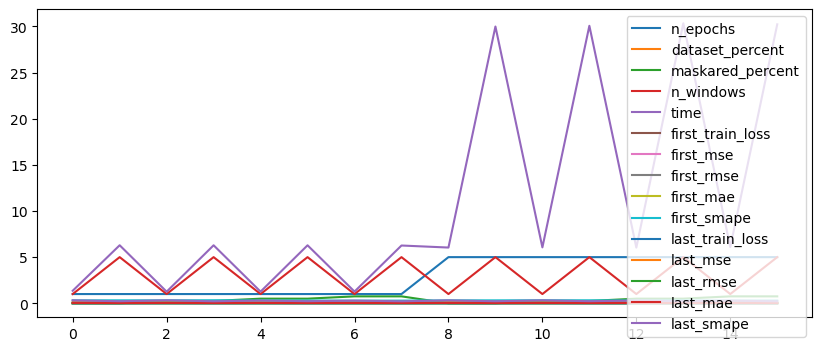

In [38]:
results_small.plot(figsize = (10,4))

<Axes: >

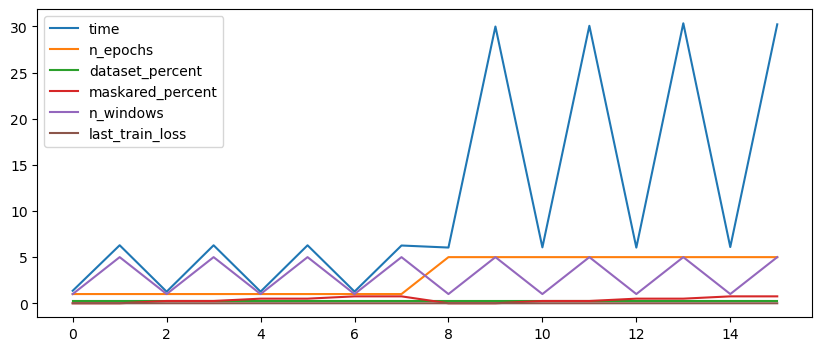

In [39]:
df_time_analysis_small = results_small[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_train_loss"]]
df_time_analysis_small.plot(figsize = (10,4))

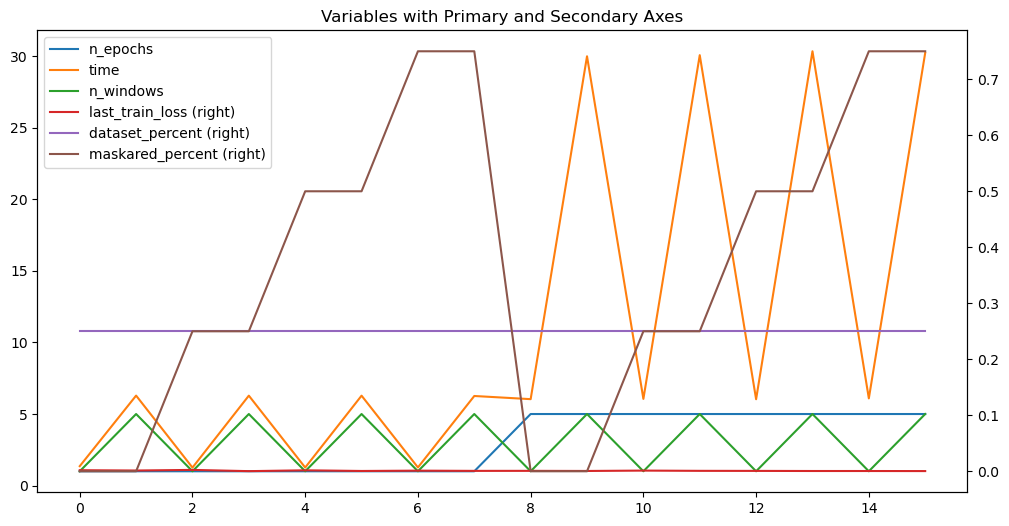

In [40]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time", "n_windows"], ["last_train_loss", "dataset_percent", "maskared_percent"])

In [52]:
profile_small_df = df_time_analysis_small.copy(deep = True)

In [ ]:
#profile_small.to_notebook_iframe()

In [47]:
profile_small_df.head()

,time,n_epochs,dataset_percent,maskared_percent,n_windows,last_train_loss
0,1.356896,1,0.25,0,1,0.001909
1,6.287416,1,0.25,0,5,0.001346
2,1.257235,1,0.25,0.25,1,0.002447
3,6.284177,1,0.25,0.25,5,0.000230
4,1.262461,1,0.25,0.5,1,0.001733


In [53]:
print(profile_small_df.dtypes)

time                float64
n_epochs             object
dataset_percent     float64
maskared_percent     object
n_windows            object
last_train_loss     float64
dtype: object


In [54]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir maskared_percent a float, manejando posibles errores
profile_small_df['maskared_percent'] = pd.to_numeric(profile_small_df['maskared_percent'], errors='coerce').astype(float)

In [55]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

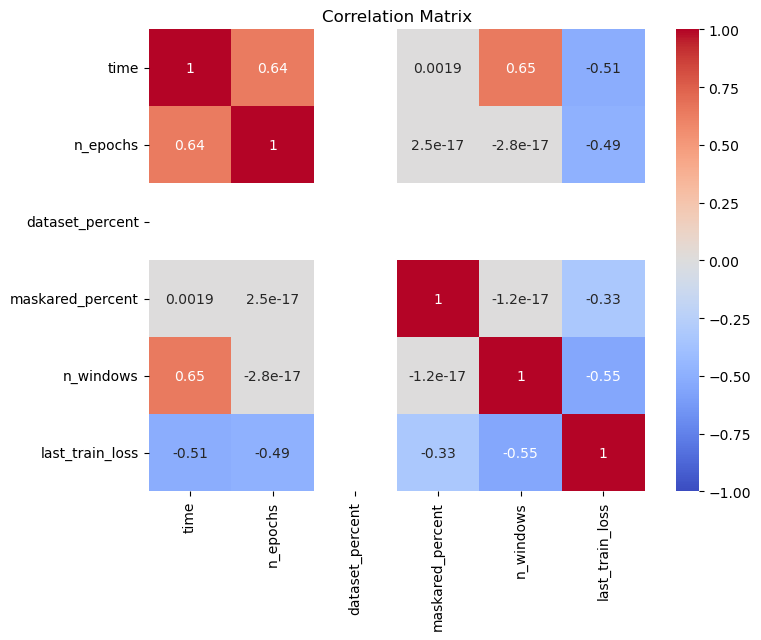

In [56]:
 plot_correlation(profile_small_df)

A nivel de tiempo, se observa que:

- Apenas afecta el enmascarado, con una correlación negativa con el last loss. Lo mismo ocurre con el n_epochs
- Más tiempo parece hacer crecer el last_loss
- Lo que más influye es el porcentaje de dataset utilizado para el fine_tuning. Más dataset parece hacer empeorar por alguna razón
- El last loss está bastante relacionado con el tiempo dedicado al fine-tuning, como es de esperar. Pero. La correlación es positiva => más last loss => más tiempo.
- El número de ventanas parece ir en contra de bajar el loss.. quizá porque va de la mano del número de ventanas.


### Loss & metrics analysis

A nivel de losses, se observa (sin tener en cuenta mse, rmse, mae, smape): 
- Muy poca relación con el enmascarado, cosa que de primeras sorprende
- Mucha relación con el % de dataset utilizado en el fine-tuning
Por lo tanto,
    - vamos a filtrar el dataset para tener tiempos menores a 8 segundos
y buenos losses.
    - Veamos a partir de qué momento se obtienen unos losses razonables  en %.

In [57]:
results_small.columns

Index(['model_size', 'n_epochs', 'dataset_percent', 'maskared_percent',
       'n_windows', 'time', 'first_train_loss', 'first_mse', 'first_rmse',
       'first_mae', 'first_smape', 'last_train_loss', 'last_mse', 'last_rmse',
       'last_mae', 'last_smape', 'windows'],
      dtype='object')

In [75]:
df_loss_small = results_small[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()

<Axes: >

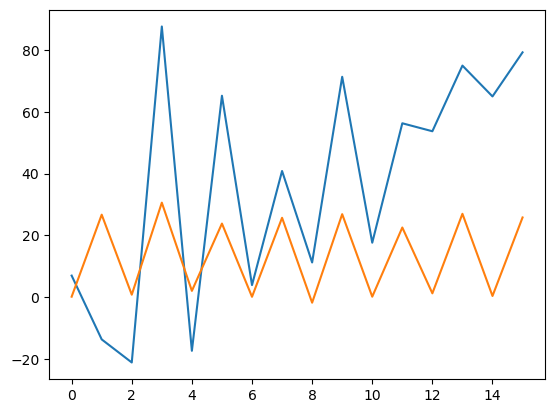

In [77]:
df_loss_small["loss_train_percent"] = (df_loss_small['first_train_loss']-df_loss_small['last_train_loss'])*100/(df_loss_small['first_train_loss'])
df_loss_small["loss_train_percent"].plot()
df_loss_small["mse_percent"] = (df_loss_small['first_mse']-df_loss_small['last_mse'])*100/(df_loss_small['first_mse'])
df_loss_small["mse_percent"].plot()

<Axes: >

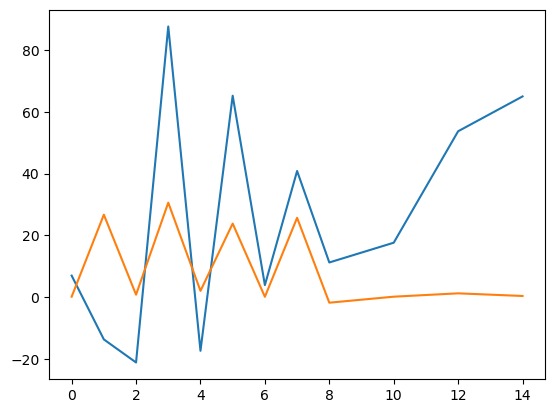

In [79]:
df_loss_small[df_loss_small["time"] < 8]["loss_train_percent"].plot()
df_loss_small[df_loss_small["time"] < 8]["mse_percent"].plot()

In [80]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_small_best_cases = df_loss_small[df_loss_small["time"] < 8].copy()

print("--------------------- Train -----------------")
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('loss_train_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_train_percent', ascending = False)[:5])
print("---------------------- Eval ------------------")
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_train_percent', ascending = False)[:5])

--------------------- Train -----------------


,time,n_epochs,dataset_percent,maskared_percent,n_windows,first_train_loss,last_train_loss,first_mse,last_mse,loss_train_percent,mse_percent
3,6.284177,1,0.25,0.25,5,0.001852,0.000230,0.068438,0.047487,87.562017,30.613616
5,6.282633,1,0.25,0.5,5,0.001564,0.000545,0.061181,0.046587,65.172185,23.853189
14,6.093034,5,0.25,0.75,1,0.001326,0.000465,0.058282,0.058022,64.948800,0.446119
12,6.033468,5,0.25,0.5,1,0.001459,0.000676,0.061103,0.060308,53.693254,1.300470
7,6.259730,1,0.25,0.75,5,0.001194,0.000706,0.057717,0.042873,40.846746,25.718464


,time,n_epochs,dataset_percent,maskared_percent,n_windows,first_train_loss,last_train_loss,first_mse,last_mse,loss_train_percent,mse_percent
3,6.284177,1,0.25,0.25,5,0.001852,0.000230,0.068438,0.047487,87.562017,30.613616
5,6.282633,1,0.25,0.5,5,0.001564,0.000545,0.061181,0.046587,65.172185,23.853189
14,6.093034,5,0.25,0.75,1,0.001326,0.000465,0.058282,0.058022,64.948800,0.446119
12,6.033468,5,0.25,0.5,1,0.001459,0.000676,0.061103,0.060308,53.693254,1.300470
7,6.259730,1,0.25,0.75,5,0.001194,0.000706,0.057717,0.042873,40.846746,25.718464


---------------------- Eval ------------------


,time,n_epochs,dataset_percent,maskared_percent,n_windows,first_train_loss,last_train_loss,first_mse,last_mse,loss_train_percent,mse_percent
3,6.284177,1,0.25,0.25,5,0.001852,0.000230,0.068438,0.047487,87.562017,30.613616
1,6.287416,1,0.25,0,5,0.001185,0.001346,0.065972,0.048338,-13.594122,26.728938
7,6.259730,1,0.25,0.75,5,0.001194,0.000706,0.057717,0.042873,40.846746,25.718464
5,6.282633,1,0.25,0.5,5,0.001564,0.000545,0.061181,0.046587,65.172185,23.853189
4,1.262461,1,0.25,0.5,1,0.001478,0.001733,0.061883,0.060586,-17.274737,2.094497


,time,n_epochs,dataset_percent,maskared_percent,n_windows,first_train_loss,last_train_loss,first_mse,last_mse,loss_train_percent,mse_percent
3,6.284177,1,0.25,0.25,5,0.001852,0.000230,0.068438,0.047487,87.562017,30.613616
5,6.282633,1,0.25,0.5,5,0.001564,0.000545,0.061181,0.046587,65.172185,23.853189
14,6.093034,5,0.25,0.75,1,0.001326,0.000465,0.058282,0.058022,64.948800,0.446119
12,6.033468,5,0.25,0.5,1,0.001459,0.000676,0.061103,0.060308,53.693254,1.300470
7,6.259730,1,0.25,0.75,5,0.001194,0.000706,0.057717,0.042873,40.846746,25.718464


In [84]:
df_loss_small.columns

Index(['time', 'n_epochs', 'dataset_percent', 'maskared_percent', 'n_windows',
       'first_train_loss', 'last_train_loss', 'first_mse', 'last_mse',
       'loss_train_percent', 'mse_percent'],
      dtype='object')

In [85]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df = df_loss_small[['time', 'n_epochs', 'dataset_percent', 'maskared_percent', 'n_windows', 'loss_train_percent', 'mse_percent']].copy()
profile_small_df.dtypes

time                  float64
n_epochs               object
dataset_percent       float64
maskared_percent       object
n_windows              object
loss_train_percent    float64
mse_percent           float64
dtype: object

In [86]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')
# Convertir maskared_percent a float, manejando posibles errores
profile_small_df['maskared_percent'] = pd.to_numeric(profile_small_df['maskared_percent'], errors='coerce').astype(float)

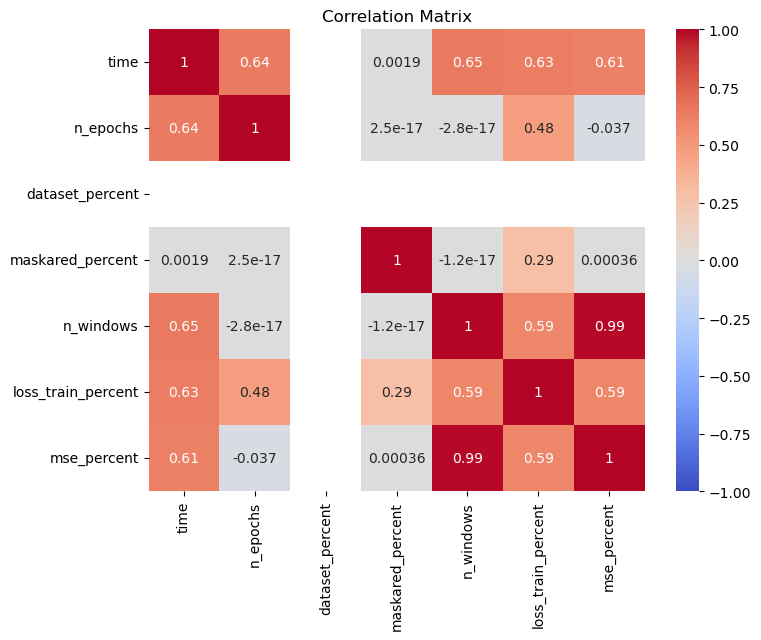

In [87]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_loss_small'", explorative=True)
plot_correlation(profile_small_df)

#### What if I focus on 0.25 dataset percent?

In [69]:
profile_small_df_2 = df_time_analysis_small[df_time_analysis_small['dataset_percent'] == 0.25].drop(columns=['dataset_percent', 'time']).copy()

In [70]:
profile_small_df_2.dtypes

n_epochs              Int64
maskared_percent     object
n_windows            object
last_train_loss     float64
dtype: object

In [71]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df_2['n_epochs'] = pd.to_numeric(profile_small_df_2['n_epochs'], errors='coerce').astype('Int64')
profile_small_df_2['n_windows'] = pd.to_numeric(profile_small_df_2['n_windows'], errors='coerce').astype('Int64')
# Convertir maskared_percent a float, manejando posibles errores
profile_small_df_2['maskared_percent'] = pd.to_numeric(profile_small_df_2['maskared_percent'], errors='coerce').astype(float)

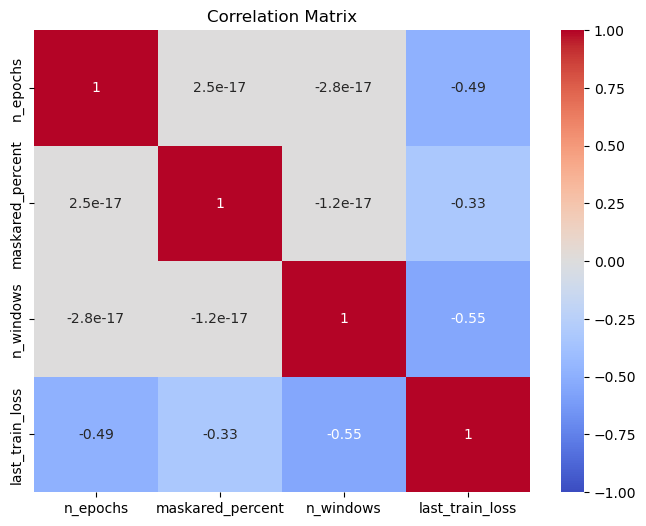

In [72]:
profile_small_2 = ydp.ProfileReport(profile_small_df_2, title="Pandas Profiling Report for 'df_time_analysis_small' for < 0.25 dataset percent", explorative=True)
plot_correlation(profile_small_df_2)

* Correlación inversa entre maskared percent y last loss * => Aumentar maskared percent baja last_loss
* => Es parte de lo que queremos!

In [ ]:
#! ls errors*

In [ ]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

## Moment-base

### Download the model

In [ ]:
print("Getting base artifact: ", enc_artifact_base_name)
enc_artifact_base  = wandb_api.artifact(enc_artifact_base_name, type='learner')
moment_base  = enc_artifact_base.to_obj()

### Select parameters

In [90]:
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")
n_epochs_list_base= [5, 10, 20]
dataset_percents_base  = [0.25, 0.5]
maskared_percents_base = [ 0.25, 0.5, 0.75]
sizes_base             = [1, 5, 10]
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(maskared_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

Total cases: 360
Total cases: 90
Expected time: 43.77764713764191 seconds | 0.7296274522940318 minutes | 0.012160457538233863 hours


### Configure files and wether already computed or not

In [ ]:
already_computed_base = False
results_base = None
errors_base = None
file_errors_base = 'errors_base_24012025_1.csv'
file_results_base = 'results_base_24012025_1.csv'

### Execute cases

In [ ]:
results_base = None
errors_base = None
if already_computed_base:
    results_base = pd.read_csv(file_results_base, index_col=None, header=0)
    errors_base = pd.read_csv(file_errors_base, index_col=None, header=0)
else:
    results_base, errors_base = cases_loop(
        model             = moment_base, 
        n_epochs_list     = n_epochs_list_base, 
        dataset_percents  = dataset_percents_base, 
        maskared_percents = maskared_percents_base,
        n_sizes_list      = sizes_base, 
        summarized        = True,
        verbose           = 8
    )
    results_base.to_csv(file_results_base, index=False, header=True)
    errors_base.to_csv(file_errors_base, index=False, header=True)
    already_computed_base = True

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_base)}")
display(errors_base.head())
print(f"Total results: {len(results_base)}")
display(results_base.head())

### Checking the errors

In [ ]:
error_base_window_sizes = list(errors_base['windows'].drop_duplicates())
error_base_window_sizes

In [ ]:
error_base_mssg = errors_base['error'].astype(str).drop_duplicates()
error_base_mssg

In [ ]:
base_windows = results_base['windows'].drop_duplicates()
filtered_windows_base = base_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows_base

#### Time analysis

In [ ]:
df_time_analysis_base = results_base[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_loss", "last_mse"]]

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_base, ["n_epochs", "time", "n_windows"], ["last_loss", "dataset_percent", "maskared_percent", "last_mse"])

In [ ]:
profile_base_df = df_time_analysis_base.copy(deep = True)
profile_base = ydp.ProfileReport(profile_base_df, title="Pandas Profiling Report for 'df_time_analysis_base'", explorative=True)

In [ ]:
plot_correlation(profile_base_df)

#### Loss & metrics analysis

In [ ]:
df_loss_base = results_base[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_loss", "last_loss", "first_mse", "last_mse"]].copy()
df_loss_base["loss_percent"] = (df_loss_base['first_loss']-df_loss_base['last_loss'])*100/(df_loss_base['first_loss'])
df_loss_base["loss_percent"].plot()
df_loss_base["mse_percent"] = (df_loss_base['first_mse']-df_loss_base['last_mse'])*100/(df_loss_base['first_mse'])
df_loss_base["mse_percent"].plot()

In [ ]:
df_loss_base[df_loss_base["time"] < 8]["loss_percent"].plot()
df_loss_base[df_loss_base["time"] < 8]["mse_percent"].plot()

In [ ]:
df_loss_base[df_loss_base["time"] < 20]

In [ ]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_base_best_cases = df_loss_base[df_loss_base["time"] < 8].copy()

print("---- Mejoras en el entrenamiento ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
print("---- Mejoras en la validación  ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('mse_percent', ascending = False)[:5])

In [ ]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

## Moment-large

### Download de large model

In [ ]:
print("Getting large artifact: ", enc_artifact_large_name)
enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
print(enc_artifact_large.name)
moment_large = enc_artifact_large.to_obj()

In [ ]:
print(count_parameters(moment_large))

In [ ]:
torch.cuda.memory_allocated()

In [ ]:
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(maskared_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

n_epochs_list_large     = [5, 10, 20]
dataset_percents_large  = [0.25, 0.5] # No tendría sentido porque sería como hacer lo mismo que con mvp
maskared_percents_large = [0.25, 0.5, 0.75]
sizes_large             = [1, 5, 10]
print(f"Total cases: {len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)}")

In [ ]:
torch.cuda.memory_allocated()
torch.cuda.set_device(1)
torch.cuda.current_device()

In [ ]:
results_large, errors_large = cases_loop(
    model             = moment_large, 
    n_epochs_list     = n_epochs_list_large,
    dataset_percents  = dataset_percents_large, 
    maskared_percents = maskared_percents_large, 
    n_sizes_list      = sizes_large, 
    summarized        = True
)
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())
print("------------------")

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_large.to('cpu')
for param in enc_learner_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
gc.collect()
print("Mejorado: ", after-before)

#### Errors analysis

In [ ]:
error_large_window_sizes = list(errors_large['window'].drop_duplicates())
error_large_window_sizes

In [ ]:
try:
    error_large_mssg = errors_large['error'].astype(str).drop_duplcates()
    display(error_large_mssg)
except Exception as e:
    print(e)

In [ ]:
large_windows = results_large['windows'].drop_duplicates()
print(large_windows.shape)
display(large_windows)

In [ ]:
filtered_windows_large = large_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
display(filtered_windows_large)

#### Time analysis

In [ ]:
df_time_analysis_large = results_large[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_loss"]]
df_time_analysis_large.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_large, ["n_epochs", "time", "n_windows"], ["last_loss", "dataset_percent", "maskared_percent"])

In [ ]:
profile_large_df = df_time_analysis_large.copy(deep = True)
profile_large = ydp.ProfileReport(profile_large_df, title = "Pandas Profiling Report for 'df_time_analysis_large'", explorative = True)
#profile_large.to_notebook_iframe()

In [ ]:
plot_correlation(profile_large_df)

In [ ]:
df_loss_large = results_large[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_loss", "last_loss"]].copy()

In [ ]:
df_loss_large["loss_percent"] = (df_loss_large['first_loss']-df_loss_large['last_loss'])*100/(df_loss_large['first_loss'])
df_loss_large["loss_percent"].plot()

In [ ]:
df_loss_large_best_cases = df_loss_large[df_loss_large["time"] < 8].copy()
df_loss_large_beset_cases = df_loss_large_best_cases[df_loss_large_best_cases["loss_percent"] > 0]
print(df_loss_large_best_cases.shape)
display(df_loss_large_best_cases)

In [ ]:
display(df_loss_large_best_cases.sort_values('loss_percent'))

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
gc.collect()
torch.cuda.empty_cache()
after = torch.cuda.memory_allocated()
print(after)
print(after-before)

In [ ]:
gpu_tensors = []
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            gpu_tensors.append(obj)
    except ReferenceError:
        continue # Omitir los objetos que ya han sido recolectados
print(len(gpu_tensors))

#### Loss & metrics analysis

In [ ]:
#| export
if verbose > 0: print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    os._exit(00)

# Memory checks

In [ ]:
snapshot = torch.cuda.memory_snapshot()
gpu_tensors = [obj['tensor'] for obj in snapshot if 'tensor' in obj]
for tensor_info in gpu_tensors:
    print(f"Size: {tensor_info['size']}, Device: {tensor_info['device']}, Data type: {tensor_info['dtype']}")
print(gpu_tensors)

In [ ]:
object_types = set()
for obj in snapshot:
    for key in obj.keys():
        object_types.add(key)
print("Tipos de objetos encontrados en el snapshot:")
for obj_type in sorted(object_types):
    print(obj_type)
heavier_obj = None
for obj in snapshot:
    if heavier_obj is None or obj['total_size'] > heavier_obj['total_size']: heavier_obj = obj
print(heavier_obj)

In [ ]:
before = torch.cuda.memory_allocated()
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_small.to('cpu')
for param in enc_learner_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_base.to('cpu')
for param in enc_learner_base.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_large.to('cpu')
for param in enc_learner_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
results_small.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)